# Homework 2 - Jingwen Li

## FINM 35700 - Spring 2023

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on:

- the US government bonds symbology file `govt_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the corporate  bonds symbology file `corp_symbology` and
- the market data file `market_prices_eod`.


# Problem 1: Constructing fixed rate bonds

In [103]:
import QuantLib as ql
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Use static calculation/valuation date of 2023-04-14, matching data available in the market prices EOD file
calc_date = ql.Date(14, 4, 2023)
ql.Settings.instance().evaluationDate = calc_date

## a. Prepare common symbology dataframe for fixed rate government and corporate bonds

Load the `govt_symbology` and `corp_symbology` Excel files into one common dataframe, using the `corp_symbology` columns. Filter the dataframe and keep fixed rate bonds only: (cpn_type="FIXED").


In [8]:
govt_symbology = pd.read_excel('govt_symbology.xlsx')
corp_symbology = pd.read_excel('corp_symbology.xlsx')

symbology = pd.concat([govt_symbology, corp_symbology], ignore_index=True)
symbology = symbology[symbology['cpn_type']=='FIXED']

symbology['term'] = (symbology['maturity'] - symbology['start_date']).dt.days / 365.25
symbology['TTM'] = (symbology['maturity'] - pd.Timestamp('2023-04-14')).dt.days / 365.25

symbology

,ticker,class,figi,isin,trace,security,name,type,coupon,cpn_type,...,cpn_first,acc_first,maturity,country,currency,und_bench_isin,mty_typ,rank,term,TTM
50,T,Govt,BBG000DLJF04,US912810EQ77,TSRYS4493810,T 6 1/4 08/15/23,US TREASURY N/B,US GOVERNMENT,6.250,FIXED,...,1994-02-15,1993-08-15,2023-08-15,US,USD,NaN,NaN,NaN,29.995893,0.336756
51,T,Govt,BBG000DKZWK9,US912810ES34,TSRYS4493811,T 7 1/2 11/15/24,US TREASURY N/B,US GOVERNMENT,7.500,FIXED,...,1994-11-15,1994-05-15,2024-11-15,US,USD,NaN,NaN,NaN,30.253251,1.590691
52,T,Govt,BBG000DLBVY0,US912810ET17,TSRYS4493812,T 7 5/8 02/15/25,US TREASURY N/B,US GOVERNMENT,7.625,FIXED,...,1995-08-15,1995-02-15,2025-02-15,US,USD,NaN,NaN,NaN,30.001369,1.842574
53,T,Govt,BBG000DQQNJ8,US912810EV62,TSRYS4493813,T 6 7/8 08/15/25,US TREASURY N/B,US GOVERNMENT,6.875,FIXED,...,1996-02-15,1995-08-15,2025-08-15,US,USD,NaN,NaN,NaN,30.001369,2.338125
54,T,Govt,BBG000DPXMD0,US912810EW46,TSRYS4493814,T 6 02/15/26,US TREASURY N/B,US GOVERNMENT,6.000,FIXED,...,1996-08-15,1996-02-15,2026-02-15,US,USD,NaN,NaN,NaN,30.001369,2.841889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,VZ,Corp,BBG017BR3G75,US92346MJT99,VZ5414106,VZ 4.15 05/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.150,FIXED,...,2022-11-15,2022-05-19,2029-05-15,US,USD,US91282CGT27,CALLABLE,Sr Unsecured,6.989733,6.086242
643,VZ,Corp,BBG017QYK9Z0,US92346MJZ59,VZ5420578,VZ 4.65 06/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.650,FIXED,...,2022-12-15,2022-06-03,2052-06-15,US,USD,US912810TL26,CALLABLE,Sr Unsecured,30.034223,29.171800
644,VZ,Corp,BBG0191HMXJ3,US92346MKG59,VZ5458130,VZ 4.6 08/15/52,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.600,FIXED,...,2023-02-15,2022-08-11,2052-08-15,US,USD,US912810TL26,CALLABLE,Sr Unsecured,30.012320,29.338809
645,VZ,Corp,BBG019LXC9P3,US92346MKQ32,VZ5477070,VZ 4 1/2 09/15/29,VERIZON COMMUNICATIONS,DOMESTIC MTN,4.500,FIXED,...,2023-03-15,2022-09-22,2029-09-15,US,USD,US91282CGT27,CALLABLE,Sr Unsecured,6.981520,6.422998


## b. Add function to construct generic fixed rate cashflow schedules from symbology data

Use one row of the symbology dataframe as input  to the function. Use the helper function to convert a date string to a QuantLib date object.

In [18]:
def get_ql_date(date) -> ql.Date:
    """
    convert dt.date to ql.Date
    """
    if isinstance(date, dt.date):
        return ql.Date(date.day, date.month, date.year)
    elif isinstance(date, str):
        date = dt.datetime.strptime(date, "%Y-%m-%d").date()
        return ql.Date(date.day, date.month, date.year)
    else:
        raise ValueError(f"to_qldate, {type(date)}, {date}")

In [19]:
def create_schedule_from_symbology(details: dict):
    '''Create a QuantLib cashflow schedule from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    # Create maturity from details['maturity']
    maturity = get_ql_date(details['maturity'])   # use date helper function and update code !!!
    
    # Create acc_first from details['acc_first']
    acc_first = get_ql_date(details['acc_first'])   # use date helper function and update code !!!
    
    # Create calendar for Corp and Govt asset classes
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    
    # define period from details['cpn_freq'] ... can be hard-coded to 2 = semi-annual frequency
    period = ql.Period(2)
    
    # business_day_convention
    business_day_convention = ql.Unadjusted
    
    # termination_date_convention
    termination_date_convention = ql.Unadjusted
    
    # date_generation
    date_generation=ql.DateGeneration.Backward
    
    # Create schedule using ql.MakeSchedule interface (with keyword arguments)
    schedule = ql.MakeSchedule(effectiveDate=acc_first,  # this may not be the same as the bond's start date
                            terminationDate=maturity,
                            tenor=period,
                            calendar=calendar,
                            convention=business_day_convention,
                            terminalDateConvention=termination_date_convention,
                            rule=date_generation,
                            endOfMonth=True,
                            firstDate=ql.Date(),
                            nextToLastDate=ql.Date())
    return schedule

In [28]:
# Test on row 0
schedule = create_schedule_from_symbology(symbology.iloc[0].to_dict())

print(f"Schedule for {symbology.iloc[0]['ticker']}:")
print(f"Effective date: {schedule.startDate()}")
print(f"Termination date: {schedule.endDate()}")
print(f"Coupon frequency: {schedule.tenor()}")
print(f"Cashflow dates: {[d.to_date().isoformat() for d in schedule]}")


Schedule for T:
Effective date: August 15th, 1993
Termination date: August 15th, 2023
Coupon frequency: 6M
Cashflow dates: ['1993-08-15', '1994-02-15', '1994-08-15', '1995-02-15', '1995-08-15', '1996-02-15', '1996-08-15', '1997-02-15', '1997-08-15', '1998-02-15', '1998-08-15', '1999-02-15', '1999-08-15', '2000-02-15', '2000-08-15', '2001-02-15', '2001-08-15', '2002-02-15', '2002-08-15', '2003-02-15', '2003-08-15', '2004-02-15', '2004-08-15', '2005-02-15', '2005-08-15', '2006-02-15', '2006-08-15', '2007-02-15', '2007-08-15', '2008-02-15', '2008-08-15', '2009-02-15', '2009-08-15', '2010-02-15', '2010-08-15', '2011-02-15', '2011-08-15', '2012-02-15', '2012-08-15', '2013-02-15', '2013-08-15', '2014-02-15', '2014-08-15', '2015-02-15', '2015-08-15', '2016-02-15', '2016-08-15', '2017-02-15', '2017-08-15', '2018-02-15', '2018-08-15', '2019-02-15', '2019-08-15', '2020-02-15', '2020-08-15', '2021-02-15', '2021-08-15', '2022-02-15', '2022-08-15', '2023-02-15', '2023-08-15']


## c. Add function to construct generic fixed rate bond objects from symbology data

Use one row of the symbology dataframe as input to the function. Use create_schedule_from_symbology() internally to create the cashflow schedule.

In [29]:
def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporates use ql.Thirty360(ql.Thirty360.USA)
    day_count = ql.Thirty360(ql.Thirty360.USA)   # update code depending on dcc !!!
    
    # Create day_count from details['start_date']    
    issue_date = ql.Date()    # use date helper function and update code !!!
    
    # Create days_settle from details['days_settle']
    days_settle = int(float(details['days_settle']))

    # Create days_settle from details['coupon']
    coupon = float(details['coupon'])/100.

    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond


## d. Add function that returns a dataframe with (future) cash flows details for a bond object

Use the "Investigate Bond Cashflows" section in the Quantlib introductory notebook as a template.

The results dataframe should contain following columns:


| CashFlowDate | CashFlowAmount | CashFlowYearFrac |
|----------|-------|-------------|

Pick one government and one corporate bond from symbology, create the bond objects and display the future cashflows.

In [31]:
def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=lambda: ql.Settings.instance().evaluationDate()) -> pd.DataFrame:
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    '''    
    # create a list to store the cash flows data
    cashflows = []
    
    # iterate over the cashflows of the bond
    for i, cf in enumerate(bond.cashflows()):
        # check if the cashflow date is after the calculation date
        if cf.date() > calc_date():
            # extract the relevant information and append to the cashflows list
            cashflows.append([cf.date().ISO(), cf.amount(), ql.ActualActual().yearFraction(calc_date(), cf.date())])

    # update code!!!
    cashflows_df = pd.DataFrame(cashflows, columns=['CashFlowDate', 'CashFlowAmount', 'CashFlowYearFrac'])
    
    return cashflows_df

# Problem 2: US Treasury yield curve calibration (On-The-Runs)

## a. Create the on-the-run US treasury bond objects

Restrict the symbology + market data dataframe to on-the-run US treasury notes only (excluding Treasury Bills) and create the treasury bond objects.

Extend the treasuries symbology dataframe with the following market data columns (code from Homework 1):


| date | bid | ask | mid | bid_yield | ask_yield | mid_yield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

In [37]:
market_data = pd.read_excel('market_prices_eod-1.xlsx')

market_data['mid_yield'] = (market_data['bid_yield'] + market_data['ask_yield'])/2
market_data['mid'] = (market_data['bid'] + market_data['ask'])/2

market_data['term'] = np.nan
market_data['TTM'] = np.nan

for i in market_data['isin']:
    if i in symbology['isin'].values:
        ttm = symbology.loc[symbology['isin'] == i, 'TTM'].values[0]
        term = symbology.loc[symbology['isin'] == i, 'term'].values[0]
        market_data.loc[market_data['isin'] == i, 'TTM'] = ttm
        market_data.loc[market_data['isin'] == i, 'term'] = term
  
market_data = market_data[market_data['TTM'].notna()]
market_data = pd.merge(market_data, symbology, on='isin', how='left')
market_data = market_data.rename(columns={'TTM_y': 'TTM', 'term_y': 'term'})
market_data[['date','bid','ask','mid','bid_yield','ask_yield','mid_yield','term','TTM']]

,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,term,TTM
0,2023-04-14,98.6780,98.8480,98.76300,4.679,4.551,4.6150,4.815880,1.423682
1,2023-04-14,98.4540,98.8210,98.63750,4.361,4.203,4.2820,5.897331,2.505133
2,2023-04-14,97.0900,97.3690,97.22950,4.260,4.174,4.2170,6.981520,3.589322
3,2023-04-14,115.1630,115.9840,115.57350,4.624,4.529,4.5765,13.311431,9.919233
4,2023-04-14,112.9390,113.5860,113.26250,4.742,4.674,4.7080,15.063655,11.671458
...,...,...,...,...,...,...,...,...,...
546,2023-04-14,102.1250,102.1563,102.14065,3.845,3.834,3.8395,3.000684,2.918549
547,2023-04-14,100.3750,100.4375,100.40625,3.563,3.553,3.5580,7.000684,6.962355
548,2023-04-14,100.0703,100.0859,100.07810,3.609,3.606,3.6075,5.002053,4.963723
549,2023-04-14,99.5703,99.5820,99.57615,4.105,4.099,4.1020,2.001369,1.963039


In [44]:
govt_on_the_run = pd.read_excel('govt_on_the_run.xlsx')
tenors = ['2', '3', '5', '7', '10', '20', '30']
tickers = [f'GT{tenor} Govt' for tenor in tenors]
govt_on_the_run = govt_on_the_run.query('ticker in @tickers')
govt_on_the_run.reset_index(drop=True, inplace=True)
govt_on_the_run

,ticker,date,isin,figi
0,GT10 Govt,2023-04-14,US91282CGM73,BBG01DVKBC66
1,GT2 Govt,2023-04-14,US91282CGU99,BBG01G14BXX2
2,GT20 Govt,2023-04-14,US912810TQ13,BBG01F6N6GN1
3,GT3 Govt,2023-04-14,US91282CGV72,BBG01G5ZMM43
4,GT30 Govt,2023-04-14,US912810TN81,BBG01DVKBH56
5,GT5 Govt,2023-04-14,US91282CGT27,BBG01G14BW91
6,GT7 Govt,2023-04-14,US91282CGS44,BBG01G14BV75


In [47]:
ts_symbology = market_data[market_data['isin'].isin(govt_on_the_run['isin'])].reset_index(drop=True)
ts_symbology[['date','bid','ask','mid','bid_yield','ask_yield','mid_yield','term','TTM']]

,date,bid,ask,mid,bid_yield,ask_yield,mid_yield,term,TTM
0,2023-04-14,97.9531,98.0313,97.99220,3.739,3.735,3.7370,30.001369,29.842574
1,2023-04-14,100.2969,100.3750,100.33595,3.853,3.847,3.8500,19.964408,19.841205
2,2023-04-14,99.8438,99.8906,99.86720,3.519,3.513,3.5160,10.001369,9.842574
3,2023-04-14,100.3750,100.4375,100.40625,3.563,3.553,3.5580,7.000684,6.962355
4,2023-04-14,100.0703,100.0859,100.07810,3.609,3.606,3.6075,5.002053,4.963723
5,2023-04-14,99.5703,99.5820,99.57615,4.105,4.099,4.1020,2.001369,1.963039
6,2023-04-14,99.7578,99.7734,99.76560,3.836,3.831,3.8335,2.995209,3.003422


## b. Calibrate the on-the-run treasury yield curve (bootstrapping)
The function below shows how to calibrate a smooth yield/discount factor curve from the on-the-run treasury dataframe. Calibrate the bid, ask and mid discount factor curves as of 2023-04-14.

In [48]:
def calibrate_yield_curve_from_frame(
        calc_date: ql.Date,
        treasury_details: pd.DataFrame,
        price_quote_column: str):
    '''Create a calibrated yield curve from a details dataframe which includes bid/ask/mid price quotes.
    '''
    ql.Settings.instance().evaluationDate = calc_date

    # Sort dataframe by maturity
    sorted_details_frame = treasury_details.sort_values(by='maturity')    
    
    # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
    day_count = ql.ActualActual(ql.ActualActual.ISMA)

    bond_helpers = []
    
    for index, row in sorted_details_frame.iterrows():
        bond_object = create_bond_from_symbology(row)
        
        tsy_clean_price_quote = row[price_quote_column]
        tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))
        
        bond_helper = ql.BondHelper(tsy_clean_price_handle, bond_object)
        bond_helpers.append(bond_helper)
        
    yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helpers, day_count)
    yield_curve.enableExtrapolation()
    return yield_curve

In [49]:
mid = calibrate_yield_curve_from_frame(ql.Date(14, 4, 2023), ts_symbology, 'mid')
bid = calibrate_yield_curve_from_frame(ql.Date(14, 4, 2023), ts_symbology, 'bid')
ask = calibrate_yield_curve_from_frame(ql.Date(14, 4, 2023), ts_symbology, 'ask')

In [51]:
mid.dates()

(Date(14,4,2023),
 Date(31,3,2025),
 Date(15,4,2026),
 Date(31,3,2028),
 Date(31,3,2030),
 Date(15,2,2033),
 Date(15,2,2043),
 Date(15,2,2053))

## c. Plot the calibrated US Treasury yield (zero rate) curves

Create a graph/scatter plot of the newly computed mid yields by maturity.

In [71]:
def plot_yield_curve_yield(mid, start_date: ql.Date, end_date: ql.Date, day_count: ql.DayCounter, label: str):
    '''Plot a yield curve from start_date to end_date using a QuantLib PiecewiseLogCubicDiscount curve.
    '''
    # Create a list of dates from start_date to end_date
    dates = [start_date + ql.Period(i, ql.Years) for i in range(0, (end_date.year() - start_date.year())+1)]
    
    # Create a list of mid yields from the yield curve for each date
    mid_yields = [mid.zeroRate(d, day_count, ql.Continuous).rate() for d in dates]
    
    # Create a dataframe of dates, discount factors and zero rates
    df = pd.DataFrame(list(zip(dates, mid_yields)), columns=['Date', 'MidYields'])
    
    #Convert Quantlib dates to Python dates
    df['Date'] = df['Date'].apply(lambda x: x.to_date())
    
    # Plot the zero rates
    plt.figure(figsize=(18, 6))
    plt.plot(df['Date'], df['MidYields'], label=label)
    # Show each year on the x-axis
    plt.xticks(df['Date'], df['Date'].apply(lambda x: x.strftime('%Y')), rotation=0)
    plt.title('Mid Yields')
    plt.xlabel('Date')
    plt.ylabel('Mid Yields')
    plt.legend()
    plt.show()
    
    return df


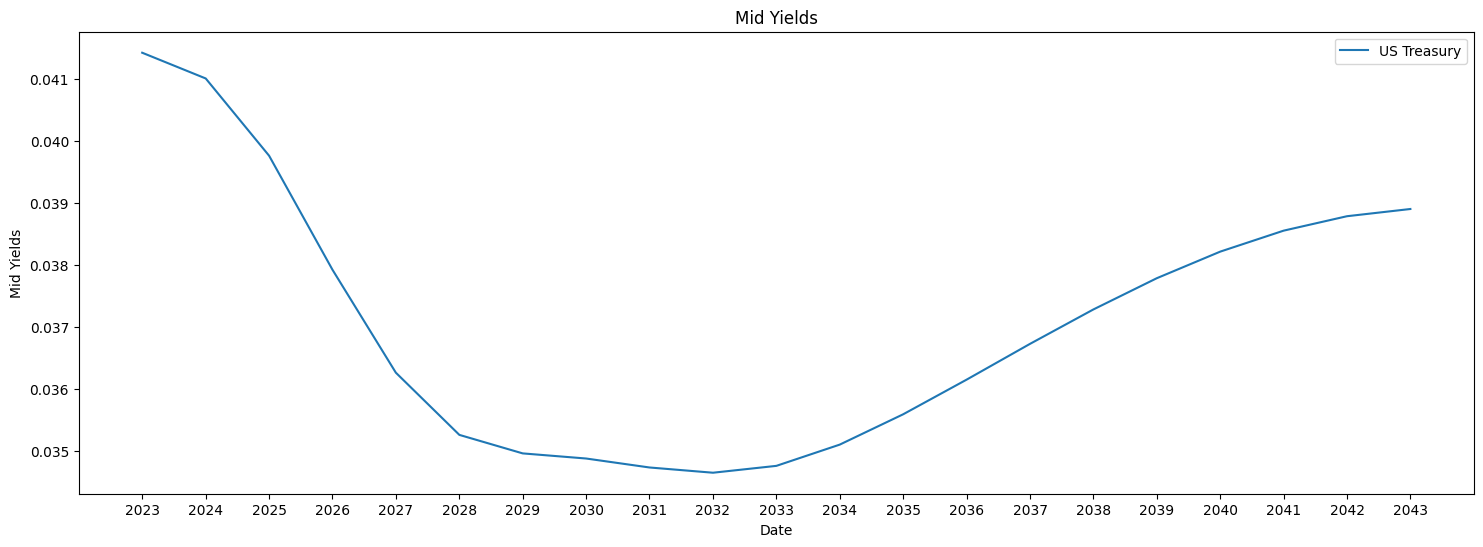

,Date,MidYields
0,2023-04-14,0.041426
1,2024-04-14,0.041011
2,2025-04-14,0.039765
3,2026-04-14,0.037927
4,2027-04-14,0.036267
5,2028-04-14,0.035264
6,2029-04-14,0.034965
7,2030-04-14,0.034883
8,2031-04-14,0.034738
9,2032-04-14,0.034654


In [72]:
plot_yield_curve_yield(mid, ql.Date(14, 4, 2023), ql.Date(14, 4, 2043), ql.ActualActual(ql.ActualActual.ISMA), 'US Treasury')

## d. Plot calibrated discount factors

Plot the discount factor curve up to the 30 years point, using a 6 months discretization grid.

In [73]:
def plot_yield_curve_discount(mid, start_date: ql.Date, end_date: ql.Date, day_count: ql.DayCounter, label: str):
    '''Plot the discount factor curve from start_date to end_date using a QuantLib PiecewiseLogCubicDiscount curve.
    '''
    # Create a list of dates from start_date to end_date
    dates_6m = [start_date + ql.Period(i, ql.Months) for i in range(0, (end_date.year() - start_date.year())*12+1, 6)]
    
    # Create a list of mid yields from the yield curve for each date
    discount_factors = [mid.discount(d) for d in dates_6m]
    
    # Create a dataframe of dates, discount factors and zero rates
    df = pd.DataFrame(list(zip(dates_6m, discount_factors)), columns=['Date', 'DiscountFactors'])
    
    #Convert Quantlib dates to Python dates
    df['Date'] = df['Date'].apply(lambda x: x.to_date())
    
    # Plot the zero rates
    plt.figure(figsize=(18, 6))
    plt.plot(df['Date'], df['DiscountFactors'], label=label)
    # Show each year on the x-axis
    plt.xticks(df['Date'], df['Date'].apply(lambda x: x.strftime('%b %Y')), rotation=45)
    plt.title('Mid Discount Factors')
    plt.xlabel('Date')
    plt.ylabel('Mid Discount Factors')
    plt.legend()
    plt.show()
    
    return df

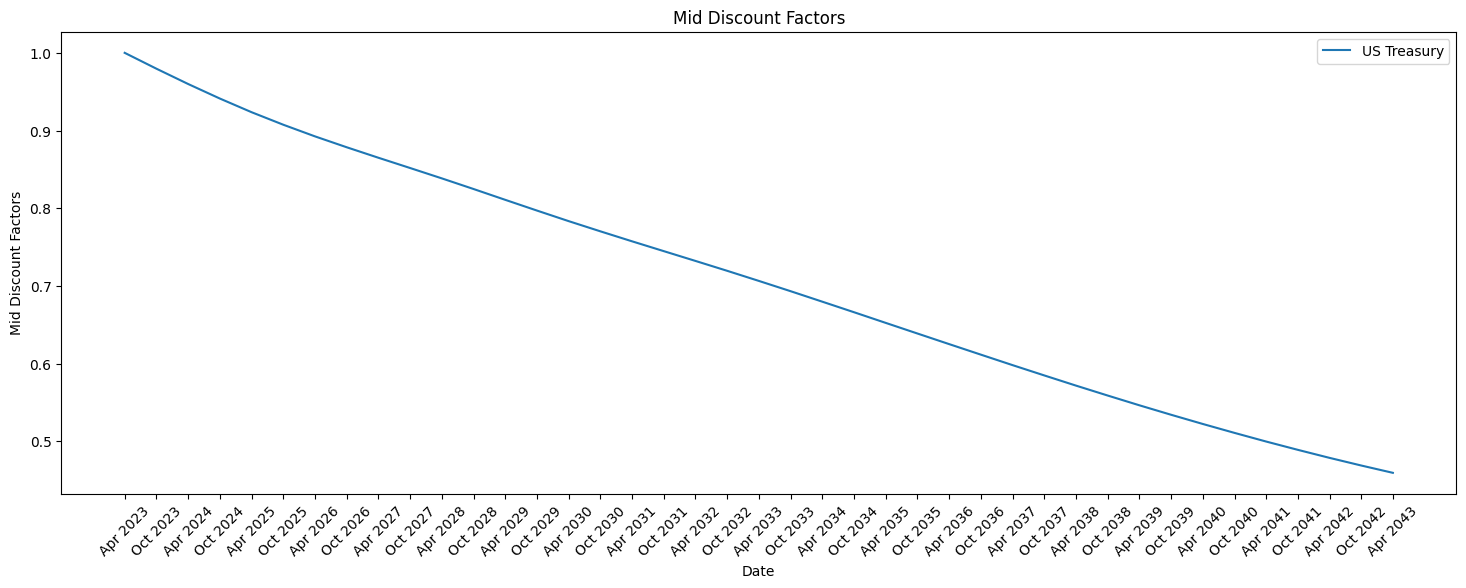

,Date,DiscountFactors
0,2023-04-14,1.000000
1,2023-10-14,0.979551
2,2024-04-14,0.959819
3,2024-10-14,0.941070
4,2025-04-14,0.923550
5,2025-10-14,0.907405
6,2026-04-14,0.892453
7,2026-10-14,0.878423
8,2027-04-14,0.864963
9,2027-10-14,0.851717


In [74]:
plot_yield_curve_discount(mid, ql.Date(14, 4, 2023), ql.Date(14, 4, 2043), ql.ActualActual(ql.ActualActual.ISMA), 'US Treasury')

# Problem 3: Pricing and risk metrics for US Treasury bonds

## a. US Treasury pricing on the calibrated discount factor curve

Follow Section 5. "Present Value Calculation (no credit risk)" in the QuantLib introductory notebook to re-price the US on-the-run treasuries using the calibrated discount factor curve. 

You will need to switch the bond_engine to use the new on-the-run treasury yield curve:
bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)

Extend the dataframe with the following computed columns for clean mid prices:


| calc_mid |
|---------------|


To validate the calibration, compare the calculated clean mid prices to the original market mid prices.

In [88]:
treasury_yield_curve_mid_handle = ql.YieldTermStructureHandle(mid)
bond_engine = ql.DiscountingBondEngine(treasury_yield_curve_mid_handle)

In [94]:
def calculate_calc_mid(row):
    bond_object = create_bond_from_symbology(row)
    bond_object.setPricingEngine(bond_engine)
    pv_engine = bond_object.NPV()
    
    return pv_engine

In [89]:
# Second code snippet
ts_clib = ts_symbology.copy()

ts_clib['calc_mid'] = ts_clib.apply(calculate_calc_mid, axis=1)

# Display the result
ts_clib[['mid', 'calc_mid']]

,mid,calc_mid
0,97.99220,98.583026
1,100.33595,100.969021
2,99.86720,100.435869
3,100.40625,100.543285
4,100.07810,100.215246
5,99.57615,99.725268
6,99.76560,99.752556


## b. Compute analytical DV01, Duration and Convexity for US on-the-run treasuries (using flat yield)

Compute analytical DV01, Duration and Convexity metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration. 

Extend the dataframe with the following calculated risk metrics:


| dv01 | duration | convexity |
|-------|-------|-------------|


In [93]:
flat_rate = ql.SimpleQuote(0.05)
compounding = ql.Compounded

def calculate_bond_metrics(row):
    fixed_rate_bond = create_bond_from_symbology(row)

    flat_int_rate = ql.InterestRate(flat_rate.value(), fixed_rate_bond.dayCounter(), compounding, ql.Semiannual)
    bond_duration = ql.BondFunctions.duration(fixed_rate_bond, flat_int_rate)
    bond_convexity = ql.BondFunctions.convexity(fixed_rate_bond, flat_int_rate)
    dv01 = row['mid_dirty'] * bond_duration
    
    return pd.Series([dv01/100, bond_duration/100, bond_convexity], index=['dv01', 'duration', 'convexity'])

In [86]:
ts_ana = ts_clib.copy()

ts_ana[['dv01', 'duration', 'convexity']] = ts_ana.apply(calculate_bond_metrics, axis=1)

# Display the result
ts_ana[['TTM', 'dv01', 'duration', 'convexity']]

,TTM,dv01,duration,convexity
0,29.842574,16.153917,0.163827,387.647946
1,19.841205,13.191662,0.130626,224.330961
2,9.842574,8.069935,0.080332,76.274011
3,6.962355,6.042090,0.060076,41.916549
4,4.963723,4.455653,0.044447,22.992532
5,1.963039,1.845028,0.018495,4.383592
6,3.003422,2.781228,0.027872,9.352688


## c. Compute scenario DV01, Duration and Convexity for US on-the-run treasuries (using calibrated yield curve)

Compute the scenario DV01, Duration and Convexity metrics using +/-1bp interest rate shocks, as described in Section 6. "Market Data Scenarios" in the QuantLib introductory notebook.

Remember that DV01 = Dirty_Price * Duration.

Extend the dataframe with the following scenario sensitivities metrics:

| scen_dv01 | scen_duration | scen_convexity |
|-------|-------|-------------|



In [91]:
# Function to calculate bond attributes
def calculate_bond_attributes(row):
    fixed_rate_bond = create_bond_from_symbology(row)

    interest_rate_bump = ql.SimpleQuote(0.0)
    flat_yield_curve_bumped = ql.ZeroSpreadedTermStructure(treasury_yield_curve_mid_handle, ql.QuoteHandle(interest_rate_bump))
    bond_engine = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(flat_yield_curve_bumped))
    fixed_rate_bond.setPricingEngine(bond_engine)
    
    price_base = fixed_rate_bond.NPV()

    # -1 bp change in yield
    interest_rate_bump.setValue(-0.0001)
    price_base_1bp = fixed_rate_bond.NPV()
    dv01 = (price_base_1bp - price_base) * 100
    bond_duration = dv01 / row['mid_dirty']

    # +1 bp change in yield
    interest_rate_bump.setValue(0.0001)
    price_base_1bp_u = fixed_rate_bond.NPV()
    bond_convexity = (price_base_1bp_u + price_base_1bp - 2 * price_base) * 1000000 / row['mid_dirty'] * 100
    
    return pd.Series([dv01, bond_duration, bond_convexity], index=['scen_dv01', 'scen_duration', 'scen_convexity'])

In [92]:
# Set evaluation date
ql.Settings.instance().evaluationDate = ql.Date(14, 4, 2023)

# Copy the original DataFrame
ts_scen = ts_ana.copy()

# Calculate bond attributes for each row in the DataFrame
ts_scen[['scen_dv01', 'scen_duration', 'scen_convexity']] = ts_scen.apply(calculate_bond_attributes, axis=1)

# Display the result
ts_scen[['TTM', 'dv01', 'duration', 'convexity', 'scen_dv01', 'scen_duration', 'scen_convexity']]

,TTM,dv01,duration,convexity,scen_dv01,scen_duration,scen_convexity
0,29.842574,16.153917,0.163827,387.647946,17.973773,0.182283,446.895727
1,19.841205,13.191662,0.130626,224.330961,14.014823,0.138777,239.669254
2,9.842574,8.069935,0.080332,76.274011,8.403097,0.083649,77.571737
3,6.962355,6.042090,0.060076,41.916549,6.288055,0.062522,41.944235
4,4.963723,4.455653,0.044447,22.992532,4.631741,0.046204,22.417520
5,1.963039,1.845028,0.018495,4.383592,1.938516,0.019433,3.839515
6,3.003422,2.781228,0.027872,9.352688,2.858797,0.028650,8.438701


# Problem 4: Pricing and risk metrics for corporate bonds

## a. Create the on-the-run corporate bond objects

Restrict the symbology dataframe to fixed rate corporate bonds only and create the corporate bond objects.

In [85]:
corp_on_the_run = market_data[market_data['class_x']=='Corp']

corp_bond_objs = {}
for i in range(corp_on_the_run.shape[0]):
    corp_bond_objs[corp_on_the_run.iloc[i]['figi_x']] = create_bond_from_symbology(corp_on_the_run.iloc[i])

## b. Compute analytical Yields and Z-Spreads

Compute analytical Yields and Z-Spreads metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_yield | calc_zspread |
|-------|-------------|


In [104]:
# using 5% flat interest rate for testing
flat_rate = ql.SimpleQuote(0.05)
rate_handle = ql.QuoteHandle(flat_rate)
day_count = ql.Actual360()
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
continuous_comp = ql.Continuous
flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)
flat_yield_curve_handle = ql.YieldTermStructureHandle(flat_yield_curve)

def calculate_yield_and_zspread(row):
    temp_bond = corp_bond_objs[row['figi_x']]
    bond_yield = temp_bond.bondYield(row['mid'], temp_bond.dayCounter(), ql.Compounded, ql.Semiannual, temp_bond.settlementDate(calc_date)) * 100
    bond_market_price = row['mid']
    zspread = ql.BondFunctions.zSpread(temp_bond, bond_market_price, flat_yield_curve, temp_bond.dayCounter(), ql.Compounded, ql.Semiannual, temp_bond.settlementDate(calc_date))
    
    return pd.Series([bond_yield, zspread], index=['calc_yield', 'calc_zspread'])

In [105]:
corp_on_the_run[['calc_yield', 'calc_zspread']] = corp_on_the_run.apply(calculate_yield_and_zspread, axis=1)

# Display the result
corp_on_the_run[['security', 'calc_yield', 'calc_zspread']]

,security,calc_yield,calc_zspread
0,DIS 3.7 09/15/24,4.614951,-0.005294
1,DIS 3.7 10/15/25,4.282205,-0.008474
2,DIS 3 3/8 11/15/26,4.217295,-0.009109
3,DIS 6.55 03/15/33,4.576707,-0.005532
4,DIS 6.2 12/15/34,4.707902,-0.004247
...,...,...,...
214,VZ 4.15 05/15/29,4.960332,-0.001754
215,VZ 4.65 06/15/52,5.478765,0.003352
216,VZ 4.6 08/15/52,5.440080,0.002966
217,VZ 4 1/2 09/15/29,4.784810,-0.003505


## c. Validate Z-Spread computation for a few fixed rate corporate bonds

Pick 3 corporate bonds (at your discretion) and use function below to re-price them using the calibrated flat z-spread. Follow the example in Section 9. "Duration, Convexity and Z-Spread (flat yield model)".

Validate that you match the original market price, which were used as input to the z-Spread function.


In [107]:
def calc_clean_price_with_zspread(fixed_rate_bond, yield_curve_handle, zspread):
    zspread_quote = ql.SimpleQuote(zspread)
    zspread_quote_handle = ql.QuoteHandle(zspread_quote)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, zspread_quote_handle, ql.Compounded, ql.Semiannual)
    yield_curve_bumped_handle = ql.YieldTermStructureHandle(yield_curve_bumped)
    
    # Set Valuation engine
    bond_engine = ql.DiscountingBondEngine(yield_curve_bumped_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)
    bond_clean_price = fixed_rate_bond.cleanPrice()
    return bond_clean_price


In [108]:
# Randomly pick 3 bonds
random_bonds = corp_on_the_run.sample(3)

# Create an empty DataFrame to store bond information
bond_info = pd.DataFrame(columns=['Bond', 'ZSpread_bps', 'Market_Price', 'ZSpread_Clean_Price', 'Difference'])

for index, row in random_bonds.iterrows():
    bond = corp_bond_objs[row['figi_x']]
    bond_market_price = row['mid']
    bond_zspread = row['calc_zspread']
    bond_zspread_clean_price = calc_clean_price_with_zspread(bond, flat_yield_curve_handle, bond_zspread)
    difference = bond_market_price - bond_zspread_clean_price
    
    bond_info = bond_info.append({
        'Bond': row['security'],
        'ZSpread_bps': round(bond_zspread * 10000, 2),
        'Market_Price': bond_market_price,
        'ZSpread_Clean_Price': bond_zspread_clean_price,
        'Difference': difference
    }, ignore_index=True)

# Display the bond information DataFrame
bond_info

,Bond,ZSpread_bps,Market_Price,ZSpread_Clean_Price,Difference
0,ORCL 3 1/4 11/15/27,-42.74,94.0635,94.0635,-2.842171e-13
1,DIS 6.2 12/15/34,-42.47,113.2625,113.2625,-3.298339e-11
2,VZ 2.05 05/15/30,30.64,80.2640,80.2640,8.898837e-11


## d. Compute Duration and Convexity for fixed rate corporate bonds (using flat yield)

Compute analytical Duration and Convexity metrics, as described in Section 9. "Duration, Convexity and Z-Spread (flat yield model)" in the QuantLib introductory notebook.

Extend the dataframe with the following calculated risk metrics:


| calc_duration | calc_convexity |
|-------|-------------|


In [110]:
fixed_rate_bond_cal = corp_on_the_run.copy()

fixed_rate_bond_cal[['dv01', 'calc_duration','calc_convexity']] = fixed_rate_bond_cal.apply(calculate_bond_metrics, axis=1)

# Display the result
fixed_rate_bond_cal[['security','calc_yield','calc_zspread','calc_duration','calc_convexity']]

,security,calc_yield,calc_zspread,calc_duration,calc_convexity
0,DIS 3.7 09/15/24,4.614951,-0.005294,0.013473,2.493466
1,DIS 3.7 10/15/25,4.282205,-0.008474,0.023423,6.751805
2,DIS 3 3/8 11/15/26,4.217295,-0.009109,0.032603,12.731333
3,DIS 6.55 03/15/33,4.576707,-0.005532,0.073741,67.816971
4,DIS 6.2 12/15/34,4.707902,-0.004247,0.082778,87.729796
...,...,...,...,...,...
214,VZ 4.15 05/15/29,4.960332,-0.001754,0.051869,31.969098
215,VZ 4.65 06/15/52,5.478765,0.003352,0.152390,343.563214
216,VZ 4.6 08/15/52,5.440080,0.002966,0.154368,349.916013
217,VZ 4 1/2 09/15/29,4.784810,-0.003505,0.054656,35.196260
